<font face="Calibri" size="2"> <i>Open SAR Toolkit - Tips and Tricks, version 1.0, September 2019. Andreas Vollrath, ESA/ESRIN phi-lab</i>
</font>

![title](auxiliary/header_image.PNG)

--------

# OST Tips and Tricks

This notebook provides code snippets that might be useful for specific OST usage.

--------

**Short description**

This notebook shows some useful low level functionality of OST, as well as some tricks that can be helpful for certain projects. 

- **1:** Create a squared AOI from point coordinates
- **2:** Create a OST confrom download directory from already downloaded files
- **3:** Create the Time of Interest using python's datatime class
- **4:** Load an already created inventory file into a OST class instance.
- **5:** How to download an offline scene from ESA scihub archive
- **6:** Speed up processing by using a ram disk for temporary file storage
--------

### 1 - Create a squared AOI from Lat/Lon point coordinates

In case you do not have a shapefile of your Area Of Interest (AOI), but rather want to define it by Latitude and Longitude, considering a buffer, there is a helper function that let you do exactly this. 

**Note** that there are 2 buffer options, in meter and in degree, respectively. The buffer in meter does the transform from Lat/Lon into meters based on a equidistant projection. This may result in non-sqaured rectangles towards the poles when plotting on Lat/Lon grid (see second cell)

In [1]:
# import of of vector helper functions of ost
from ost.helpers import vector

# define point by lat/lon coordinates
lat, lon = '78', '12'

# apply function with buffer in meters
wkt1 = vector.latlon_to_wkt(lat, lon, buffer_degree=0.5, envelope=True)
wkt2 = vector.latlon_to_wkt(lat, lon, buffer_meter=10000, envelope=True)
print(wkt1)
print(wkt2)

POLYGON ((11.5000000000000000 77.5000000000000000, 12.5000000000000000 77.5000000000000000, 12.5000000000000000 78.5000000000000000, 11.5000000000000000 78.5000000000000000, 11.5000000000000000 77.5000000000000000))
POLYGON ((11.5693278865807017 77.9104302440645569, 12.4306721134192983 77.9104302440645569, 12.4306721134192983 78.0895691803596321, 11.5693278865807017 78.0895691803596321, 11.5693278865807017 77.9104302440645569))


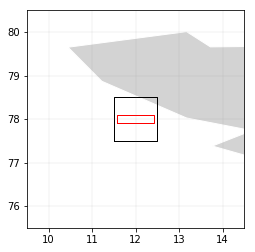

In [2]:
# we plot the wkt with geopandas and matplotlib
import geopandas as gpd
import matplotlib.pyplot as plt

# load world borders for background
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# import aoi as gdf
aoi1 = vector.wkt_to_gdf(wkt1)
aoi2 = vector.wkt_to_gdf(wkt2)
# get bounds of AOI
bounds = aoi1.geometry.bounds
# get world map as base
base = world.plot(color='lightgrey', edgecolor='white')
# plot aoi
aoi1.plot(ax=base, color='None', edgecolor='black')
aoi2.plot(ax=base, color='None', edgecolor='red')

# set bounds
plt.xlim([bounds.minx.min()-2, bounds.maxx.max()+2])
plt.ylim([bounds.miny.min()-2, bounds.maxy.max()+2])
plt.grid(color='grey', linestyle='-', linewidth=0.1)

### 2 Create a OST conform download directory

OST stores downloaded data in a certain directory hierarchy. In case you already downloaded your Sentinel-1 data by yourself, you can automatically create an OST conform directory, where all scenes found in the input directory, will be moved into its hierarchical structure. 

In [8]:
from ost.s1_core import s1_dl

input_directory = '/home/jovyan/download'
output_directory = '/home/jovyan/tips_and_tricks_download'
s1_dl.restore_download_dir(input_directory, output_directory)


### 3 Create the Time of Interest using python's datetime class

Sometimes it is wanted to create dynamic timestamps for the defintion of time of interest. Here we show python's datetime library is used in combination with the OST format needed for class instantion. 

#### 3.1. Last 30 days from today onwards.

**Note**, we do not need to set an end date, since this is by default today.

In [9]:
from datetime import datetime, timedelta
start_date = (datetime.today() - timedelta(days=30)).strftime("%Y-%m-%d")
print(start_date)

2020-01-21


#### 3.2. Target day (create date range around a certain date)

In [10]:
# we set only the start date to today - 30 days
target_day = '2018-11-28'
delta_days = 60

# we set start and end 60 days before, repsectively after event
start = (datetime.strptime(target_day, "%Y-%m-%d") - timedelta(days=delta_days)).strftime("%Y-%m-%d")
end = (datetime.strptime(target_day, "%Y-%m-%d") + timedelta(days=delta_days)).strftime("%Y-%m-%d")

print(start, end)

2018-09-29 2019-01-27


### 4 Load an already created inventory file into a OST class instance. 

Sometimes you need ot re-initialize the one of the batch processing classes. This results in an empty inventory atttriubte. In order ot skip the search on scihub you can load an already created inventory shapefile and set it as attribute in the following way:

In [11]:
s1_class = Sentinel1Batch(args)
s1_class.inventory_file = '/path/to/inventory/shapefile.shp'
s1_class.read_inventory()

NameError: name 'Sentinel1Batch' is not defined

### 5 How to download an offline scene from ESA scihub archive

ESA's scihub catalogue features an rolling archive of Sentinel-1 data meaning that older products are offline and need to be produced on demand. OST provides the functionality to do that in a programmatic way.

In [2]:
from ost import Sentinel1Scene
from ost.helpers.scihub import connect

# create instance
s1 = Sentinel1Scene('S1A_IW_GRDH_1SDV_20141004T230354_20141004T230423_002686_002FFD_062B')
# connection to Scihub
opener = connect()
# heck online status
print('The scene\'s online status is: ', s1.scihub_online_status(opener))

 Your Copernicus Scihub Username: suprd
 Your Copernicus Scihub Password: ·········


The scene's online status is:  False


In [3]:
from time import sleep

# trigger production
s1.scihub_trigger_production(opener)
status = False
# let's run a loop until the scene is online
while status is False:
    sleep(60)     # just to not ask every millisecond, production can take a while
    status = s1.scihub_online_status(opener) 
    print(status)
    
s1.download('/home/jovyan/tips_and_tricks_download')    

False
False
False


KeyboardInterrupt: 

### 6 Speed up processing by using a ram disk for temporary filestorage

On UNIX systems it is possible to mount part of your RAM as a hard disk. If you have enough RAM, you can use this as a directory for temporary file storage. Since the RAM is very fast in terms of read/write operations, processing can accelareted quite a bit. 

**Note** that you need to run those commands on the command line and you will need administrative or superuser privilegues. 

Here is an example for a 30 GB big ramdisk mounted at /ramdisk:
```bash 
sudo mkdir /ramdisk
sudo mount -t tmpfs -o size=30G tmpfs /ramdisk
```
After that you can set your temp_dir to the mount point as in the following example (adjusting the other keywords for the class initialization of course)

In [ ]:
from ost import Sentinel1_SLCBatch
project = Sentinel1Batch(project_dir='/your/project/dir', 
                         aoi='your/aoi',
                         start='2019/01/01',
                         end='2019-12-31', 
                         temp_dir='/ramdisk'
                        )